In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import nltk
nltk.download('punkt')

from bertopic import BERTopic
from bertopic.representation import BaseRepresentation
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN


[nltk_data] Downloading package punkt to /Users/rbeaute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


AttributeError: module 'pandas' has no attribute 'read_txt'

In [56]:
from pathlib import Path
import pandas as pd
import nltk
nltk.download("punkt", quiet=True)

participant_id = 148
txt_path = Path(f"/Users/rbeaute/Projects/MOSAIC/DEPRESSION/{participant_id}_transcript_apple.txt")

# 1) load the raw text
with txt_path.open(encoding="utf-8") as f:
    full_text = f.read()

# 2) choose how to slice it ---------------------------
# Option A: one row = one sentence  (good default for BERTopic)
rows = nltk.sent_tokenize(full_text)

# Option B: one row = one line     (e.g. if the file is already line-separated)
# rows = full_text.splitlines()

# Option C: one row = entire document
# rows = [full_text]
# -----------------------------------------------------

# 3) wrap in a DataFrame
df = pd.DataFrame({"text": rows})

# quick sanity-check
print(df.head(), "\n", f"{len(df):,} rows loaded")

sentences = df["text"].tolist()


                                                text
0  For me, depression has been like in two phases...
1  So my first encounter with depression was pret...
2                                            Mm hmm.
3                                              Yeah.
4                     It's like high school kind of. 
 754 rows loaded


In [57]:
sentences

['For me, depression has been like in two phases, I would say.',
 "So my first encounter with depression was pretty much, I think I'm a teenage.",
 'Mm hmm.',
 'Yeah.',
 "It's like high school kind of.",
 'Yeah, high school.',
 'Because of I lost a really close friend.',
 'Oh.',
 'And I went through.',
 'I got cheated in a relationship as well.',
 'So that was like a really challenging time for me.',
 'And in terms of my househ case a lot of this narrator for me also comes from my household.',
 'So I come from a very patriarchal and very dysfunctional sort of family.',
 'So there is a lot of pressure for you to perform as a kid.',
 "So while you're constantly struggling with that pressure of performing as a kid and then simultaneous theory also losing your support system So it's it's a very difficult path for you to navigate.",
 'And at that point I did not know that there is anything like called aression.',
 'I mean, that was almost 12 years 12, 13 years back, actually, I think.',
 'S

In [58]:
len(sentences)

754

In [59]:


# # ----------------------------------------
# reports = df['reflection_answer'].tolist()
# print(f"Loaded {len(reports)} (translated) documents for BERTopic modeling.")
# # ----------------------------------------

# # ----------------------------------------
# # Divide each report into sentences
# reports_sentences = [nltk.sent_tokenize(report) for report in reports]

# sentences = [sentence for report in reports_sentences for sentence in report]
# print(f"Total number of sentences across all reports: {len(sentences)}")
# # ----------------------------------------

# filter sentences by min length
min_word_count = 3
sentences = [s for s in sentences if len(s.split()) >= min_word_count]
print(f"Total number of sentences after filtering by length: {len(sentences)}")

docs = sentences

Total number of sentences after filtering by length: 672


In [60]:
sentences

['For me, depression has been like in two phases, I would say.',
 "So my first encounter with depression was pretty much, I think I'm a teenage.",
 "It's like high school kind of.",
 'Yeah, high school.',
 'Because of I lost a really close friend.',
 'And I went through.',
 'I got cheated in a relationship as well.',
 'So that was like a really challenging time for me.',
 'And in terms of my househ case a lot of this narrator for me also comes from my household.',
 'So I come from a very patriarchal and very dysfunctional sort of family.',
 'So there is a lot of pressure for you to perform as a kid.',
 "So while you're constantly struggling with that pressure of performing as a kid and then simultaneous theory also losing your support system So it's it's a very difficult path for you to navigate.",
 'And at that point I did not know that there is anything like called aression.',
 'I mean, that was almost 12 years 12, 13 years back, actually, I think.',
 'So at that point I was not real

In [61]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import datamapplot  # For data visualization
import re  # For regular expressions

In [62]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename) #, cache_dir=path)


# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, 
            n_gpu_layers=-1, #offload all possible layers of the model to the GPU
            n_ctx=4096, 
            stop=["Q:", "\n"],
            verbose=False)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

In [63]:
prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]


The topic is described by the following keywords: '[KEYWORDS]'.


Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en-v1.5")
embeddings = embedding_model.encode(docs, show_progress_bar=True)


# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english')




# Define sub-models
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

In [64]:
topic_model = BERTopic(
 # Sub-models
 embedding_model=embedding_model,
 umap_model=umap_model,
 hdbscan_model=hdbscan_model,
 representation_model=representation_model,
 vectorizer_model=vectorizer,
 nr_topics="auto",  # Automatically determine the number of topics

 # Hyperparameters
 top_n_words=10,
 verbose=True
)


# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


# Show topics
topic_model.get_topic_info()

2025-06-24 13:43:27,597 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-24 13:43:28,446 - BERTopic - Dimensionality - Completed ✓
2025-06-24 13:43:28,447 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-24 13:43:28,460 - BERTopic - Cluster - Completed ✓
2025-06-24 13:43:28,460 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-24 13:43:28,481 - BERTopic - Representation - Completed ✓
2025-06-24 13:43:28,481 - BERTopic - Topic reduction - Reducing number of topics
2025-06-24 13:43:28,485 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 13/13 [00:22<00:00,  1.70s/it]
2025-06-24 13:43:51,733 - BERTopic - Representation - Completed ✓
2025-06-24 13:43:51,741 - BERTopic - Topic reduction - Reduced number of topics from 13 to 13


,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,148,-1_like_sudden_people_okay,"[like, sudden, people, okay, care, mean, yeah,...","[usually, especially, like, like okay, started...","[""Struggling with Mental Health"", , , , , , , ...","[But then after that, also, like probably this..."
1,0,148,0_father_family_mother_like,"[father, family, mother, like, parents, living...","[family, mother decided, father mother, happen...","[""Conflict in Family Relationships"", , , , , ,...","[And after that, my mother decided to move us ..."
2,1,137,1_ll_like_time_people,"[ll, like, time, people, want, just, know, emo...","[16 hours, stress, 14 hours, feels, 13 14 hour...","[""Mental Health Struggles and Cravings"", , , ,...","[I've become very mindful of that, but then al..."
3,2,46,2_thing_happening_time time_reasons,"[thing, happening, time time, reasons, time, p...","[thoughts occur time, strange thing oh, strang...","[""Overcoming Conflict and Self-Doubt"", , , , ,...",[This socidal thoughts also occur from time to...
4,3,38,3_blah_talking_don_really,"[blah, talking, don, really, blah blah, far, b...","[really refrain sharing, worry conflict talkin...","[""Difficulty in Open Communication"", , , , , ,...",[We'll not even talk about what happened in th...
5,4,29,4_busy_trying_ll_days,"[busy, trying, ll, days, work, ll probably, pr...","[probably spend hours, time busy going, oh bus...","[""Daily Life and Personal Plans"", , , , , , , ...",[So I try to keep up with that and I'll probab...
6,5,25,5_did_doing_built_entire,"[did, doing, built, entire, entire thing, did ...","[handed entire thing, handed entire, thing han...","[""Overwhelming Workload and Official Challenge...",[I did the all the paperwork on my own and it'...
7,6,21,6_oh_know_yeah ll_know know,"[oh, know, yeah ll, know know, normal, underst...","[oh understand know, like oh know, oh oh under...","[""Relationship Dynamics and Communication"", , ...",[The female in that house is just a follower a...
8,7,17,7_does help_help_supposed_plan,"[does help, help, supposed, plan, does, kind, ...","[does help, does help think, support does help...","[""Managing Physical and Mental Health"", , , , ...","[When you sit there, the kind of questions the..."
9,8,17,8_married_getting_getting married_going,"[married, getting, getting married, going, mar...","[thinking getting married, getting married, ok...","[""Arranged Marriage and Career Concerns"", , , ...",[Like I'm till they scared of the fact that I'...


In [65]:
topic_model.visualize_documents(docs, 
                                reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, 
                                hide_document_hover=False, 
                                custom_labels=True)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `llama-3-8b-instruct`'}>)

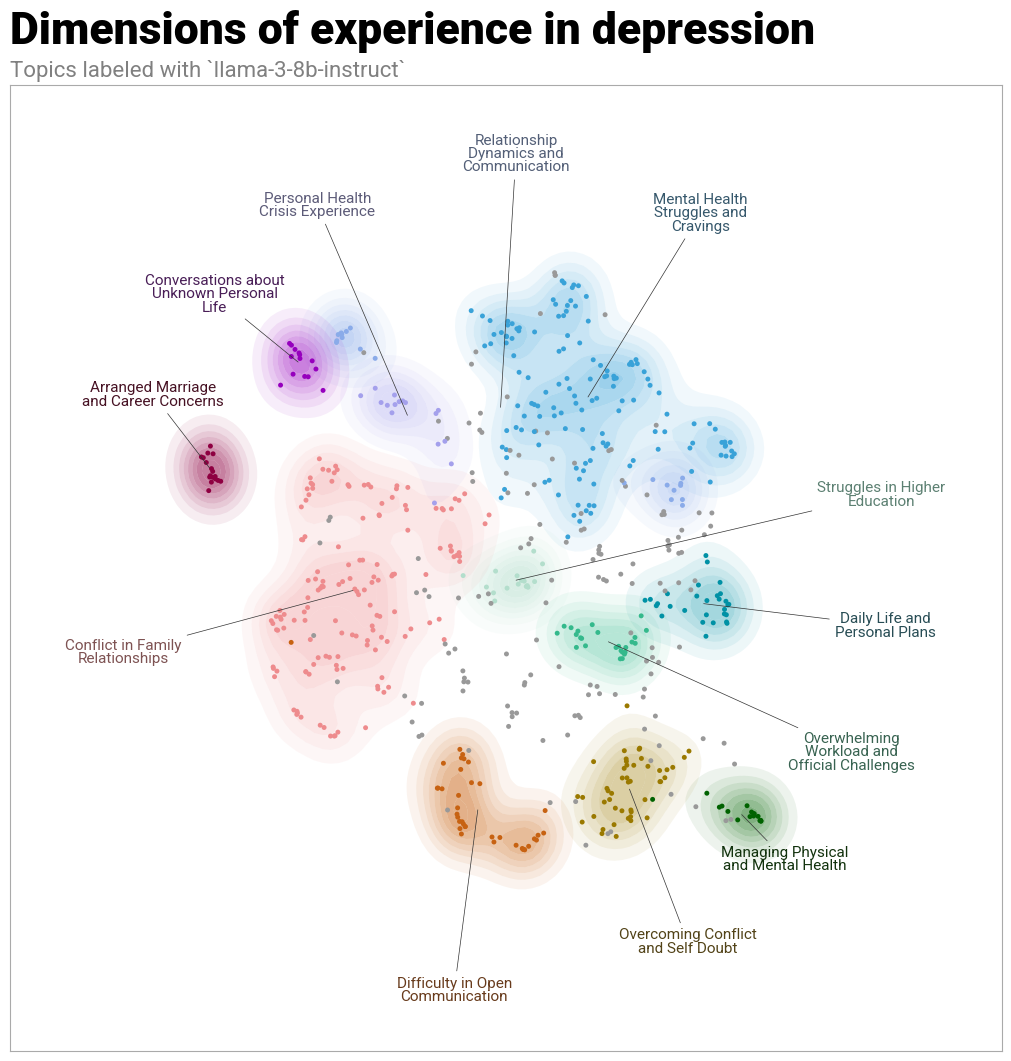

In [66]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]


# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title="Dimensions of experience in depression",
   sub_title="Topics labeled with `llama-3-8b-instruct`",
   label_wrap_width=20
)

In [67]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.9)
hierarchy_vis